In [2]:
import tensorflow as tf

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# SIFT

Definimos funciones que nos seran utiles posteriormente

In [3]:
def get_n_similar(n):
  sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)[:n]
  sorted_indexes = [int(float(tupl[0])) for tupl in sorted_counts]
  return sorted_indexes

def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(sorted_indexes):
        print(f"Solo hay {len(sorted_indexes)} imágenes en la lista. Mostrando todas.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        idx = sorted_indexes[i]
        im = cv2.cvtColor(cv2.imread(f'n04487081_{str(idx)}.JPEG'), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')

    plt.show()

Para este proyecto vamos a usar un subconjunto de imagenes de imagenet

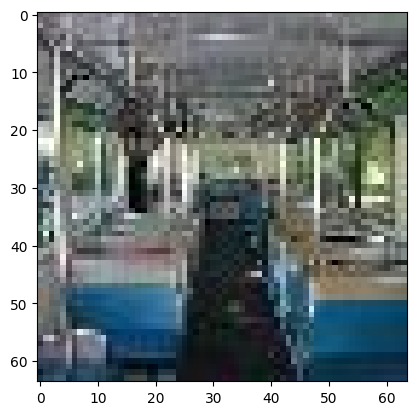

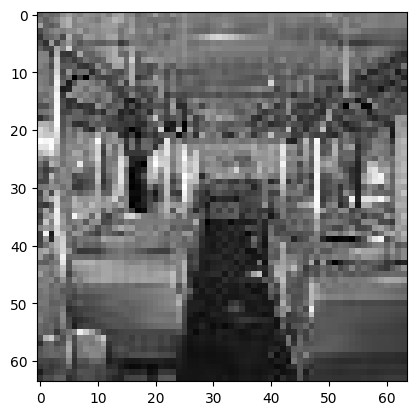

In [4]:
im1 = cv2.imread('n04487081_0.JPEG')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)
plt.show()
gray_im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im1, cmap='gray')
plt.show()

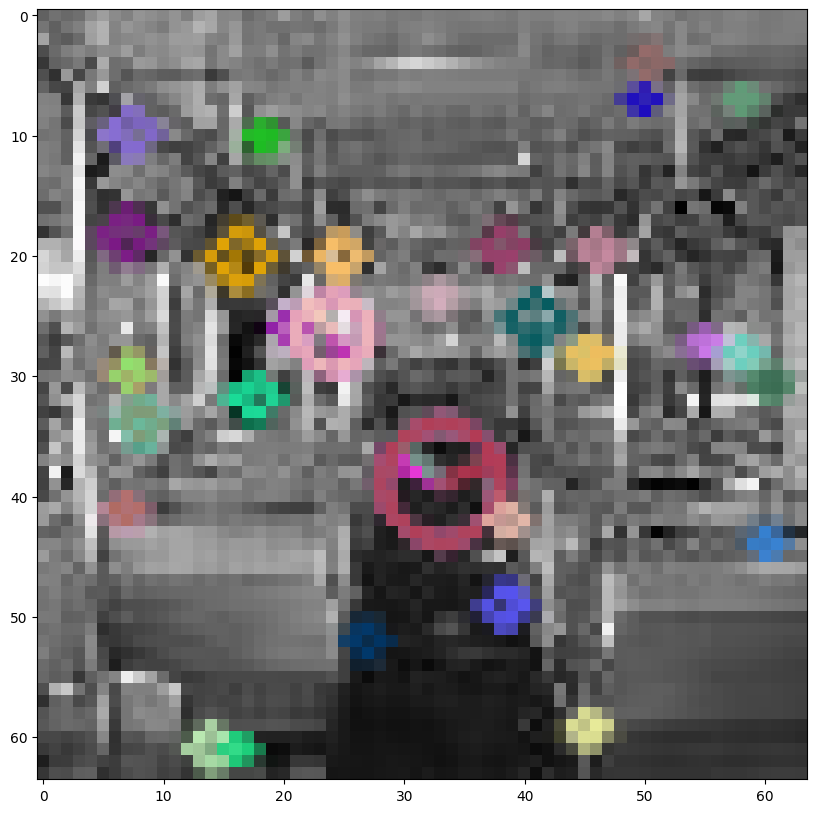

In [5]:
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(gray_im1, mask=None)
im1_sift = cv2.drawKeypoints(gray_im1, keypoints_1, im1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,10))
plt.imshow(im1_sift)
plt.show()

creamos una matriz numpy donde almacenaremos todos los descriptores con la etiqueta de la imagen a la q pertenecen

In [6]:
sift = cv2.SIFT_create()
descriptors = np.empty((0,129))
for i in range(0, 100):
  gray_im = cv2.cvtColor(cv2.imread(f'n04487081_{i}.JPEG'), cv2.COLOR_BGR2GRAY)
  _ , descriptor = sift.detectAndCompute(gray_im, mask=None)

  descriptors_arr = np.array(descriptor)
  descriptors_arr = np.insert(descriptors_arr, 0, str(i), axis=1)
  descriptors =  np.vstack([descriptors, descriptors_arr])



In [7]:
descriptors.shape

(3821, 129)

Entrenamos knn

In [8]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

descriptors_train = descriptors[:, 1:]
knn.fit(descriptors_train)

NearestNeighbors(metric='euclidean')

La estrategia para determinar las imagenes mas similares sera la siguiente:

1.- Obtenemos para cada descriptor de la imagen nueva sus 5 descriptores mas cercanos.

2.- Obtenemos los ID de las imagenes a las que pertenecen dichos descriptores.

3.- Almacenamos en un diccionario el numero de veces que aparece un descriptor de cada imagen.

4.- Recuperamos las n imagenes con mayor numero de descriptores coincidentes con los de la imagen nueva.

In [9]:
counts = {}
new_img = cv2.cvtColor(cv2.imread('n04487081_3.JPEG'), cv2.COLOR_BGR2GRAY)
_ , descriptor = sift.detectAndCompute(new_img, mask=None)
descriptors_arr = np.array(descriptor)
for descriptor_i in descriptor:
  descriptor_i = descriptor_i.reshape(1, -1)
  distance, indice = knn.kneighbors(descriptor_i, n_neighbors=5)
  for idx in indice[0]:
    id = str(descriptors[idx,0])
    if id in counts:
      counts[id] += 1
    else:
      counts[id] = 1

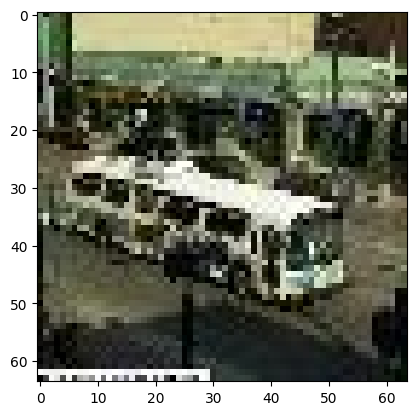

Solo hay 5 imágenes en la lista. Mostrando todas.


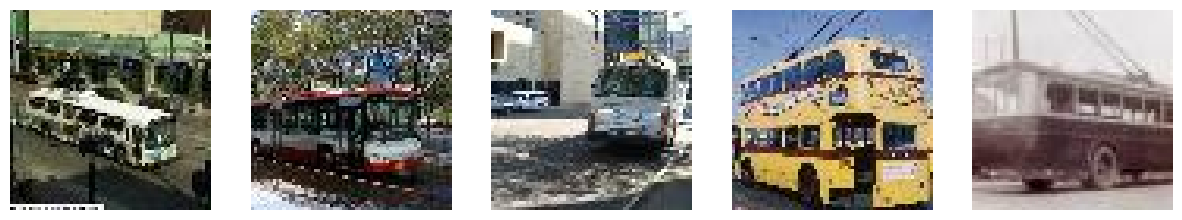

In [10]:
im1 = cv2.imread('n04487081_3.JPEG')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)
plt.show()
sorted_indexes = get_n_similar(5)
display_n_similar(sorted_indexes, 8)

# CNN

In [11]:
from keras.applications import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)


58889256/58889256 [==============================] - 0s 0us/step


In [12]:
caracteristics = np.empty((0,25089))
for i in range(0, 100):
  im = cv2.cvtColor(cv2.imread(f'n04487081_{i}.JPEG'), cv2.COLOR_BGR2RGB)
  # Redimensionar la imagen al tamaño requerido por el modelo
  target_size = (224, 224)
  im = cv2.resize(im, target_size)
  # Agregar una dimensión
  im = np.expand_dims(im, axis=0)
  # Normalizar la imagen
  im = preprocess_input(im)

  # Extraer las características de la imagen
  caracteristics_img = model.predict(im, verbose=0)
  caracteristics_flat = caracteristics_img.reshape(1, -1)
  caracteristics_flat = np.insert(caracteristics_flat, 0, str(i), axis=1)
  caracteristics =  np.vstack([caracteristics, caracteristics_flat])


In [13]:
caracteristics.shape

(100, 25089)

In [14]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

caracteristics_train = caracteristics[:, 1:]
knn.fit(caracteristics_train)

NearestNeighbors(metric='euclidean')

1/1 [==============================] - 1s 876ms/step
Solo hay 5 imágenes en la lista. Mostrando todas.


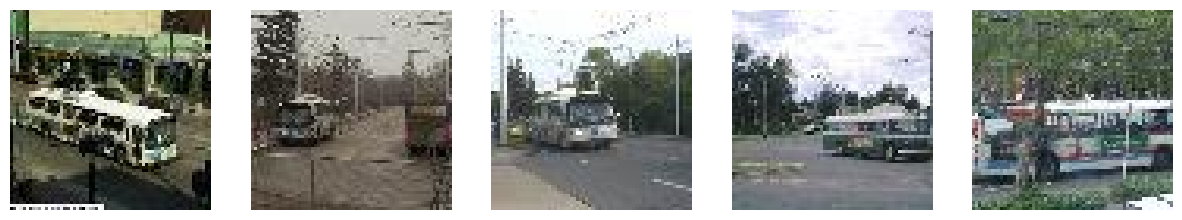

In [15]:
im = cv2.cvtColor(cv2.imread('n04487081_3.JPEG'), cv2.COLOR_BGR2RGB)
# Redimensionar la imagen al tamaño requerido por el modelo
target_size = (224, 224)
im = cv2.resize(im, target_size)
# Agregar una dimensión
im = np.expand_dims(im, axis=0)
# Normalizar la imagen
im = preprocess_input(im)

# Extraer las características de la imagen
caracteristics_img = model.predict(im)
caracteristics_flat = caracteristics_img.reshape(1, -1)
distance, indice = knn.kneighbors(caracteristics_flat, n_neighbors=5)



display_n_similar(indice[0], 8)

# HISTOGRAMA DE COLOR

In [16]:
import cv2
import numpy as np

Solo hay 5 imágenes en la lista. Mostrando todas.


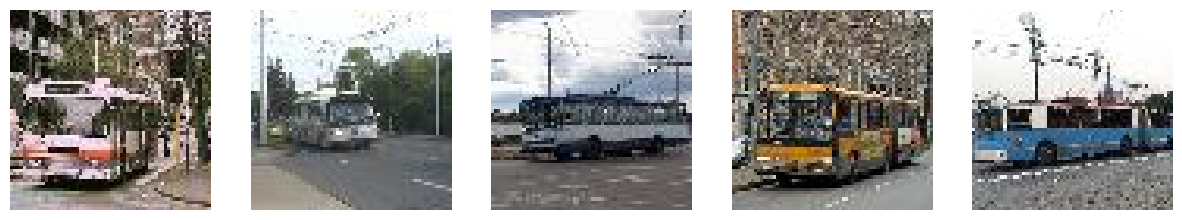

In [17]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Función para calcular el histograma de color de una imagen
def calculate_color_histogram(image, bins=8):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    histograms = []
    for i in range(3):
        hist = cv2.calcHist([hsv_image], [i], None, [bins], [0, 256])
        histograms.append(hist)
    histogram = np.concatenate(histograms)
    histogram = cv2.normalize(histogram, None).flatten()
    return histogram

# Cargar la imagen de consulta
query_image = cv2.imread('n04487081_3.JPEG')
query_histogram = calculate_color_histogram(query_image)

# Crear una matriz de histogramas para la base de datos
database_images = []
for i in range(0, 100):
  database_images =+ cv2.imread(f'n04487081_{i}.JPEG')  # Reemplaza con tus propias imágenes

database_histograms = []

for image_path in database_images:
    image =(image_path)
    hist = calculate_color_histogram(image)
    database_histograms.append(hist)

# Convertir la lista de histogramas a un array
database_histograms = np.array(database_histograms)

# Crear un modelo de k-NN
knn = NearestNeighbors(n_neighbors=5, metric='l2')  # Puedes ajustar el número de vecinos (n_neighbors) según tus necesidades

# Ajustar el modelo k-NN a los histogramas de la base de datos
knn.fit(database_histograms)

# Encontrar las imágenes más similares usando k-NN
distances, indices = knn.kneighbors([query_histogram])

# Mostrar las imágenes recuperadas más similares
display_n_similar(indices[0], 8)

#HARRIS

Solo hay 5 imágenes en la lista. Mostrando todas.


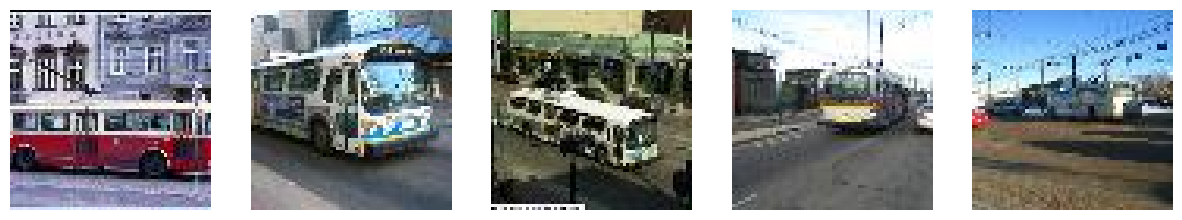

In [18]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Función para calcular los descriptores de esquinas Harris de una imagen
def calculate_harris_descriptors(image, max_corners=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detectar esquinas Harris
    dst = cv2.cornerHarris(gray_image, blockSize=2, ksize=3, k=0.04)

    # Normalizar la matriz de esquinas
    norm_dst = cv2.normalize(dst, None, 0, 255, cv2.NORM_MINMAX)

    # Encontrar las coordenadas de las esquinas
    corners = np.argwhere(norm_dst > 150)  # Puedes ajustar este umbral según tus necesidades

    # Tomar un máximo de 'max_corners' esquinas
    if len(corners) > max_corners:
        np.random.shuffle(corners)
        corners = corners[:max_corners]

    return corners

# Cargar la imagen de consulta
query_image = cv2.imread('n04487081_3.JPEG')
query_corners = calculate_harris_descriptors(query_image)

# Crear una lista de descriptores de esquinas Harris para la base de datos
database_images = []
for i in range(100):
    image_path = f'n04487081_{i}.JPEG'
    image = cv2.imread(image_path)
    database_corners = calculate_harris_descriptors(image)
    database_images.append((image, database_corners))

# Crear un modelo de k-NN
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')  # Puedes ajustar el número de vecinos (n_neighbors) y la métrica según tus necesidades

# Ajustar el modelo k-NN a los descriptores de esquinas Harris de la base de datos
# Ajustar el modelo k-NN a los descriptores de esquinas Harris de la base de datos

knn.fit(database_corners)

# Encontrar las imágenes más similares usando k-NN

query_features = np.mean(query_corners, axis=0)  # Media de las coordenadas de las esquinas
query_features = query_features.reshape(1, -1)  # Reformatear a una matriz bidimensional

# Encontrar las imágenes más similares usando k-NN
distances, indices = knn.kneighbors(query_features)

# Mostrar las imágenes recuperadas más similares
display_n_similar(indices[0], 8)



#FAST

Solo hay 5 imágenes en la lista. Mostrando todas.


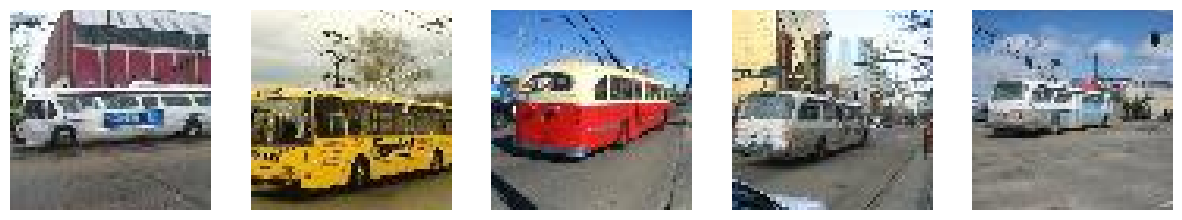

In [59]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Función para calcular los descriptores FAST de una imagen
def calculate_fast_descriptors(image, max_keypoints=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Crear el detector FAST
    fast = cv2.FastFeatureDetector_create()

    # Encontrar los keypoints
    keypoints = fast.detect(gray_image, None)

    # Tomar un máximo de 'max_keypoints' keypoints
    if len(keypoints) > max_keypoints:
        keypoints = sorted(keypoints, key=lambda x: -x.response)[:max_keypoints]

    if not keypoints:
        return [], np.zeros((0, 32), dtype=np.uint8)  # Devolver listas vacías o descriptores de ceros si no hay keypoints

    # Calcular los descriptores BRIEF para los keypoints
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    keypoints, descriptors = brief.compute(gray_image, keypoints)

    if descriptors is None or descriptors.shape[1] != 32:
        return keypoints, np.zeros((0, 32), dtype=np.uint8)  # Devolver keypoints y descriptores de ceros si no hay descriptores o no tienen 32 características

    return keypoints, descriptors


# Cargar la imagen de consulta
query_image = cv2.imread('n04487081_3.JPEG')
query_keypoints, query_descriptors = calculate_fast_descriptors(query_image)

# Crear listas de keypoints y descriptores FAST para la base de datos
database_images = []
for i in range(100):
    image_path = f'n04487081_{i}.JPEG'
    image = cv2.imread(image_path)
    database_keypoints, database_descriptors = calculate_fast_descriptors(image)
    database_images.append((image, database_keypoints, database_descriptors))

# Crear un modelo de k-NN
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')  # Puedes ajustar el número de vecinos (n_neighbors) y la métrica según tus necesidades

# Extraer los descriptores de la base de datos
database_descriptors = [item[2] for item in database_images]

# Filtrar los descriptores vacíos (None)
database_descriptors = [descriptor for adescriptor in database_descriptors if descriptor.any()]

# Verificar si hay descriptores en la base de datos
if not database_descriptors:
    print("No se detectaron descriptores en la base de datos. Asegúrate de que haya suficientes keypoints en las imágenes de la base de datos.")
else:
    # Encontrar la longitud máxima de los descriptores en la base de datos
    max_descriptor_length = max(len(descriptor) for descriptor in database_descriptors)

    # Rellenar los descriptores más cortos con ceros
    for i in range(len(database_descriptors)):
        descriptor = database_descriptors[i]
        if len(descriptor) < max_descriptor_length:
            descriptor = np.pad(descriptor, (0, max_descriptor_length - len(descriptor)), 'constant')
        database_descriptors[i] = descriptor

    # Apilar los descriptores
    database_descriptors = np.vstack(database_descriptors)

    # Ajustar el modelo k-NN a los descriptores de la base de datos
    knn.fit(database_descriptors)

    # Calcular los descriptores para la imagen de consulta
    query_descriptors = calculate_fast_descriptors(query_image)[1]

    # Encontrar las imágenes más similares usando k-NN
    distances, indices = knn.kneighbors(query_descriptors)

    # Mostrar las imágenes recuperadas más similares
    display_n_similar(indices[0], 8)
